# Warning
If you are looking for the non-technical part of this project, I would advise you to click on the following link: [Vehicle insurance cross-sell](https://github.com/cenciati/portfolio/tree/main/vehicle-insurance-cross-sell), and there you will find everything you need to know about this project.

# 0. Imports

## 0.1. Libraries

In [81]:
# data manipulation
import pandas as pd
import numpy as np
import psycopg2 as pg

# data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# preprocessing
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

# feature selection
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from boruta import BorutaPy

# machine learning
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve, plot_calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# tuning
from skopt import BayesSearchCV

# calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# other
import os
from sys import path
path.append('../src')
import joblib
from IPython.display import Image

## my tool box
from mytoolbox import MyToolBox
mtb = MyToolBox()
mtb.jupyter_settings(filterwarnings=True)

Done!


## 0.2. Helper functions

In [2]:
def precision_at_k(data, p_hat, k=1_000):
    ''' Calculate precision at k.
    (# of recommended items at k that are relevant) / (# of recommended items at k)
    
    Parameters
    ----------
    data : pandas dataframe
        The entire data to evaluate.
    p_hat : numpy array
        Predicted probabilities 
    k : int, default=1.000
        Number of most likely outcomes considered to find the correct label.
    
    Returns
    -------
    pandas dataframe.
    '''
    # create score column
    data['score'] = p_hat[:, 1].tolist()
    data = data.sort_values(by='score', ascending=False)

    # reset index
    data = data.reset_index(drop=True)
    
    # ranking
    data['ranking'] = data.index + 1
    
    # create precision at k column
    data['precision_at_k'] = np.round(data['response'].cumsum() / data['ranking'], 4)
    
    return data.loc[k, 'precision_at_k']


def recall_at_k(data, p_hat, k=1_000):
    '''Calculate recall at k.
    (# of recommended items at k that are relevant) / (total # of relevant items)

    Parameters
    ----------
    data : pandas dataframe
        The entire data to evaluate.
    p_hat : numpy array
        Predicted probabilities 
    k : int, default=1.000
        Number of most likely outcomes considered to find the correct label.
    
    Returns
    -------
    pandas dataframe.
    '''
    # create score column
    data['score'] = p_hat[:, 1].tolist()
    data = data.sort_values(by='score', ascending=False)

    # reset index
    data = data.reset_index(drop=True)
    
    # ranking
    data['ranking'] = data.index + 1
    
    # create recall at k column
    data['recall_at_k'] = np.round(data['response'].cumsum() / data['response'].sum(), 4)
    
    return data.loc[k, 'recall_at_k']


def cross_validation(estimator, x, y, n_splits=5, shuffle=False, verbose=False):
    '''Evaluate precision and recall at k of a machine learning model by cross-validation.
    
    Parameters
    ----------
    x : pandas dataframe
        The data to fit.
    y : pandas dataframe
        The target variable from the x data.
    n_splits : int, default=5
        Number of iterations.
    shuffle : boolean, default=False
        Whether the data should be shuffled.
    estimator : object
        Machine learning algorithm to evaluate. 
    verbose : boolean, default=False
        The verbosity level.
    
    Returns
    -------
    None.
    '''
    # counter
    i = 1

    # lists to store the results
    precision_at_k_list, recall_at_k_list = list(), list()
    
    skf = ms.StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    for train_ix, val_ix in skf.split(x, y):
        if verbose:
            print(f'Fold number: {i}/{n_splits}')
            i += 1
        
        # split data
        x_train = x.iloc[train_ix]
        y_train = y.iloc[train_ix]
        
        x_val = x.iloc[val_ix]
        y_val = y.iloc[val_ix]
        
        # instantiate and fit the classifier
        clf = estimator.fit(x_train, y_train)

        # predict probability
        p_hat = clf.predict_proba(x_val)
        
        # prepare data
        df = x_val.copy()
        df['response'] = y_val.astype('int64').copy()
        
        # define K
        K = np.floor((1/2) * (y_val.shape[0]))
        
        # calculate precision at k
        precision_at_k_list.append(precision_at_k(df, p_hat, K))
        
        # calculate recall at k
        recall_at_k_list.append(recall_at_k(df, p_hat, K))
    
    # print the results
    print(f'Precision@K: {np.round(np.mean(precision_at_k_list), 4)} +/- {np.round(np.std(precision_at_k_list), 4)}')
    print(f'Recall@K: {np.round(np.mean(recall_at_k_list), 4)} +/- {np.round(np.std(recall_at_k_list), 4)}')
    
    return None

## 0.3. Data acquisition
**Data source**: AWS Redshift

In [3]:
# define credentials
credentials_db = {
    'user': os.getenv('HICS_USER'),
    'password': os.getenv('HICS_PASSWORD'),
    'host': os.getenv('HICS_HOST'),
    'port': 5432,
    'database': os.getenv('HISC_DATABASE')
}

In [4]:
try:
    # create connection
    conn = pg.connect(user=credentials_db['user'],
                      password=credentials_db['password'],
                      host=credentials_db['host'],
                      port=credentials_db['port'],
                      database=credentials_db['database'])
    
    # create join tables query
    query = '''
        SELECT *
        FROM pa004.users u
            LEFT JOIN pa004.insurance i ON (u.id = i.id)
            LEFT JOIN pa004.vehicle v ON (u.id = v.id)
    '''
    
    # read tables
    df_raw = pd.read_sql(query, conn)

    # close cursor and connection
    conn.close()

except (Exception, Error) as error:
    print('Error trying to connect to the database.', error)

finally:
    if conn:
        conn.close()
        print('Connection was closed.')

Connection was closed.


In [5]:
# delete repeated id columns
columns_to_stay = list(np.append(0, np.where(df_raw.columns != 'id')[0]))
df_raw = df_raw.iloc[:, columns_to_stay]
df_raw.sample(5)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
200222,74271,Male,23,28.000,124.000,0,35803.000,30,0,1,< 1 Year,Yes
49766,15662,Male,46,28.000,25.000,0,41081.000,60,0,1,> 2 Years,Yes
172201,233248,Male,43,50.000,26.000,0,41582.000,58,0,1,1-2 Year,Yes
160713,140694,Male,71,46.000,124.000,1,36921.000,21,0,1,1-2 Year,No
53272,43931,Female,21,18.000,152.000,1,32219.000,171,0,1,< 1 Year,No


# 1. Data cleansing and description

## Index

Column | Meaning
------ | -------
id | Unique identifier
gender | Gender
age | Age
region_code | Region code
policy_sales_channel | Code identifying the customer's contact (e.g., mail, phone)
previously_insured | 0 = He/She didn't have vehicle insurance before; 1 = He/She already had vehicle insurance before
annual_premium | Amount paid per year
vintage | Number of days customers are associated with the company
response | 0 = Interested; 1 = Not interested
driving_license | 0 = He/She does not have drive license; 1 = He/She has drive license
vehicle_age | Vehicle age categorized
vehicle_damage | 0 = Vehicle was damaged before; 1 = Vehicle was not damaged before

## 1.1. Data dimensions

In [6]:
print('Rows: {:,}\nColumns: {}'.format(df_raw.shape[0], df_raw.shape[1]))

Rows: 381,109
Columns: 12


## 1.2. Duplicate data

In [7]:
df_raw.duplicated().sum()

0

## 1.3. Data types

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   annual_premium        381109 non-null  float64
 7   vintage               381109 non-null  int64  
 8   response              381109 non-null  int64  
 9   driving_license       381109 non-null  int64  
 10  vehicle_age           381109 non-null  object 
 11  vehicle_damage        381109 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [9]:
# convert to integer
for col in ['region_code', 'policy_sales_channel']:
    df_raw[col] = df_raw[col].astype('int64')

## 1.4. Missing data

In [10]:
# check null values percentage by column
(df_raw.isna().sum() /len(df_raw)).sort_values(ascending=False)

id                     0.000
gender                 0.000
age                    0.000
region_code            0.000
policy_sales_channel   0.000
previously_insured     0.000
annual_premium         0.000
vintage                0.000
response               0.000
driving_license        0.000
vehicle_age            0.000
vehicle_damage         0.000
dtype: float64

## 1.5. Outliers

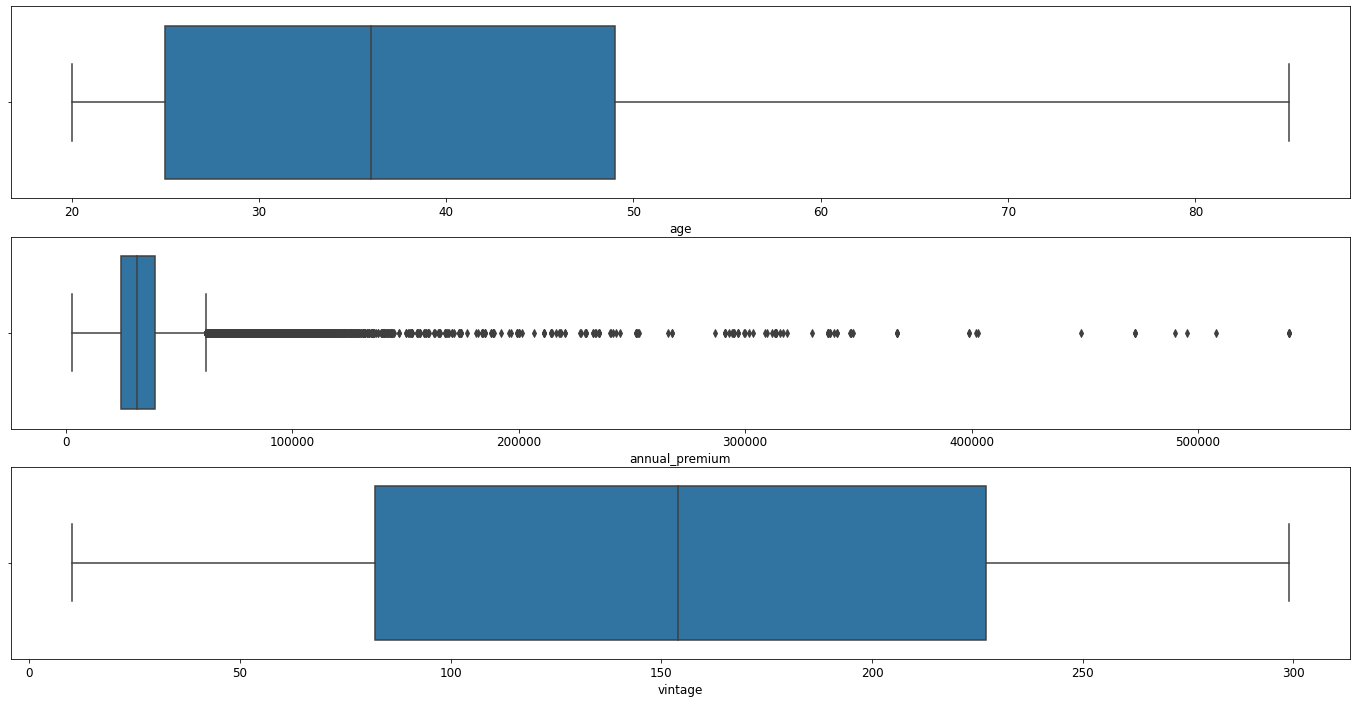

In [11]:
# define figure
_, ax = plt.subplots(nrows=3, ncols=1)
(ax1, ax2, ax3) = ax

# plot
sns.boxplot(x='age', data=df_raw, ax=ax1);
sns.boxplot(x='annual_premium', data=df_raw, ax=ax2);
sns.boxplot(x='vintage', data=df_raw, ax=ax3);

In [12]:
# rows before deleting outliers
print('Before: {:,}'.format(len(df_raw)))

# calculate quantiles
q75, q25 = np.percentile(df_raw['annual_premium'], 75), np.percentile(df_raw['annual_premium'], 25)

# calculate interquantile range
iqr = q75 - q25

# calculate outliers cut off
cut_off = 1.5 * iqr
lower, upper = q25 - cut_off, q75 + cut_off

# remove outliers
df_raw = df_raw.loc[[False if x <= lower or x >= upper else True for x in df_raw['annual_premium']]]

# rows after deleting outliers
print('After: {:,}'.format(len(df_raw)))

Before: 381,109
After: 370,789


## 1.6. Imbalance

In [13]:
df_raw['response'].value_counts(normalize=True)

0   0.878
1   0.122
Name: response, dtype: float64

## 1.7. Descriptive statistics

In [14]:
# only numerical attributes
num_attributes = df_raw[['age', 'annual_premium', 'vintage']]

# only categorical attributes
cat_attributes = df_raw.select_dtypes(include=['object', 'category'])

### 1.7.1. Numerical attributes

In [15]:
# calculate central tendency and disperion
num_attributes_stats = pd.DataFrame({'Mean': num_attributes.apply(np.mean),
                                     'Median': num_attributes.apply(np.median),
                                     'Std. deviation': num_attributes.apply(np.std),
                                     'Min': num_attributes.apply(np.min),
                                     'Max': num_attributes.apply(np.max),
                                     'Range': num_attributes.apply(lambda x: np.max(x) - np.min(x)),
                                     'Skew': num_attributes.apply(lambda x: x.skew()),
                                     'Kurtosis': num_attributes.apply(lambda x: x.kurtosis())})

# check it out
num_attributes_stats.style.highlight_max(subset=['Range', 'Skew', 'Kurtosis'], color='red')

,Mean,Median,Std. deviation,Min,Max,Range,Skew,Kurtosis
age,38.670344,36.000000,15.440145,20.000000,85.000000,65.000000,0.683788,-0.542516
annual_premium,29264.643973,31319.000000,14743.036776,2630.000000,61892.000000,59262.000000,-0.519684,-0.333414
vintage,154.345442,154.000000,83.670366,10.000000,299.000000,289.000000,0.002652,-1.200591


### 1.7.2. Categorical attributes

In [16]:
cat_attributes.describe().T

,count,unique,top,freq
gender,370789,2,Male,200319
vehicle_age,370789,3,1-2 Year,194212
vehicle_damage,370789,2,Yes,186561


# 2. Feature engineering

## 2.1. Phenomenon modeling

In [17]:
# age
df_raw['older_than_36'] = df_raw['age'].apply(lambda x: 1 if x > 36 else 0)

# vintage
df_raw['vintage_weeks'] = df_raw['vintage'].apply(lambda x: x/7)
df_raw['vintage_months'] = df_raw['vintage'].apply(lambda x: x/30)

# annual_premium
df_raw['annual_premium_per_age'] = df_raw['annual_premium'] / df_raw['age']
df_raw['annual_premium_per_vintage'] = df_raw['annual_premium'] / df_raw['vintage']
df_raw['annual_premium_per_vintage_weeks'] = df_raw['annual_premium'] / df_raw['vintage_weeks']
df_raw['annual_premium_per_vintage_months'] = df_raw['annual_premium'] / df_raw['vintage_months']

# customer characteristic
df_raw['customer_characteristic'] = df_raw['gender'].map({'Male': 0, 'Female': 1}).astype('int64')\
                                    + df_raw['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('int64')\
                                    + df_raw['vehicle_damage'].map({'No': 0, 'Yes': 1}).astype('int64')\
                                    + df_raw['previously_insured'].astype('int64')\
                                    + df_raw['age'].apply(lambda x: 2 if x >= 20 and x < 40
                                                                      else 1 if x >=40 and x < 60
                                                                      else 0)

## 2.2. Filtering

In [18]:
# df_raw[(df_raw['driving_license'] == 0) & (df_raw['vehicle_age'] != '< 1 Year')]

## Checkpoint

In [19]:
# serialize data
joblib.dump(df_raw, '../data/interim/df_cleaned.pkl')

# load cleaned data in pickle format
df = joblib.load('../data/interim/df_cleaned.pkl')

# delete old data set
del df_raw

# 3. Exploratory data analysis

## Auto EDA

In [20]:
# generate complete eda using pandas profiling
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title='Exploratory data analysis (Pandas profiling)', minimal=True)
profile.to_file('../data/interim/pp-exploratory-data-analysis.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 333.25it/s]


## 3.1. Univariate analysis

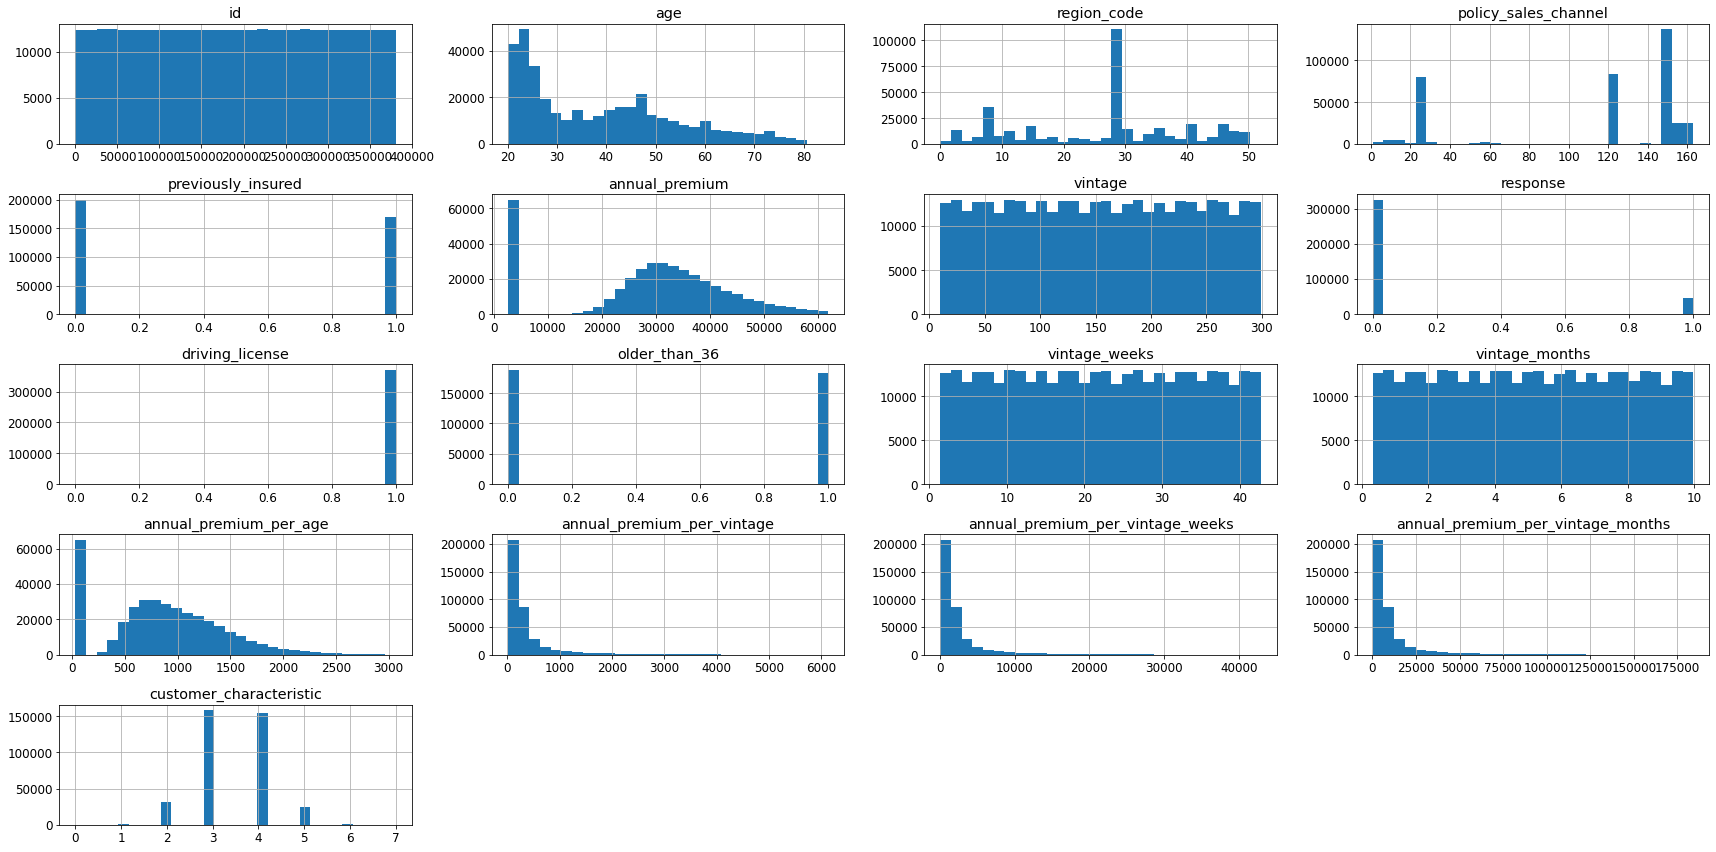

In [20]:
# plot
df.hist(bins=30);
plt.tight_layout()

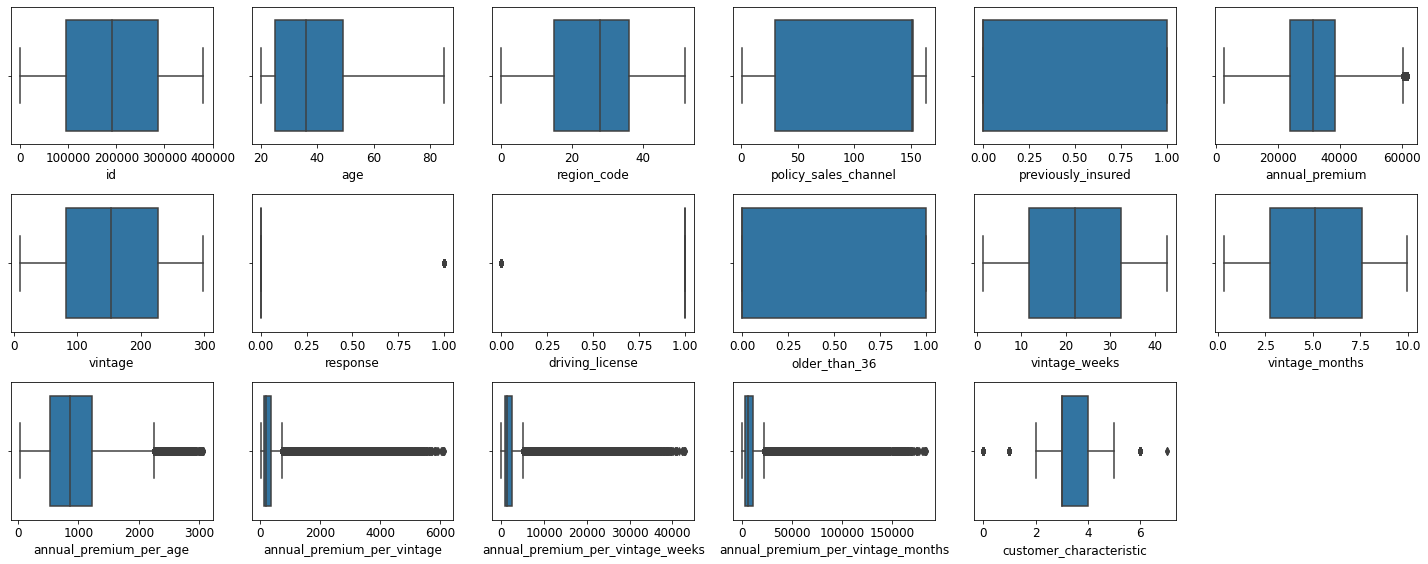

In [21]:
# plot settings
univariate_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20, 8))

# plot
for i in range(0, len(univariate_columns)):
    plt.subplot(3,6,i+1)
    sns.boxplot(x=df[univariate_columns[i]])
    plt.tight_layout()

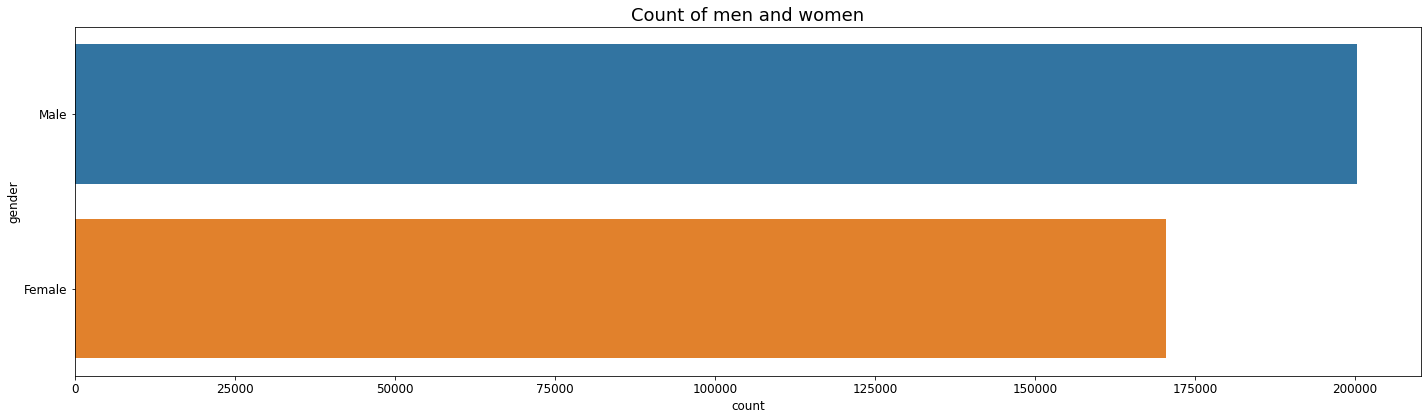

In [22]:
# plot
plt.figure(figsize=(20, 6))
sns.countplot(y=df['gender']);
plt.title('Count of men and women', fontsize=18);
plt.tight_layout()

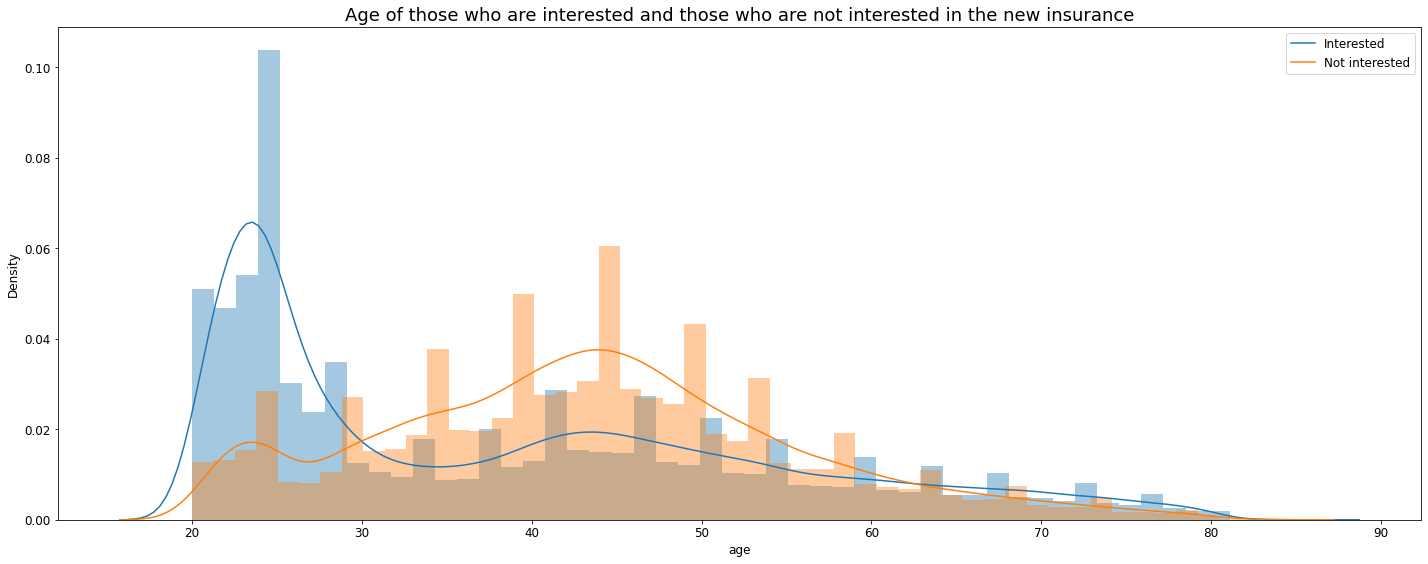

In [23]:
# plot settings
plt.figure(figsize=(20,8))

# plot
sns.distplot(df.loc[df['response'] == 0, 'age']);
sns.distplot(df.loc[df['response'] == 1, 'age']);
plt.title('Age of those who are interested and those who are not interested in the new insurance', fontsize=18);
plt.legend(['Interested', 'Not interested']);
plt.tight_layout()

## 3.2. Bivariate analysis

## Problem mind map

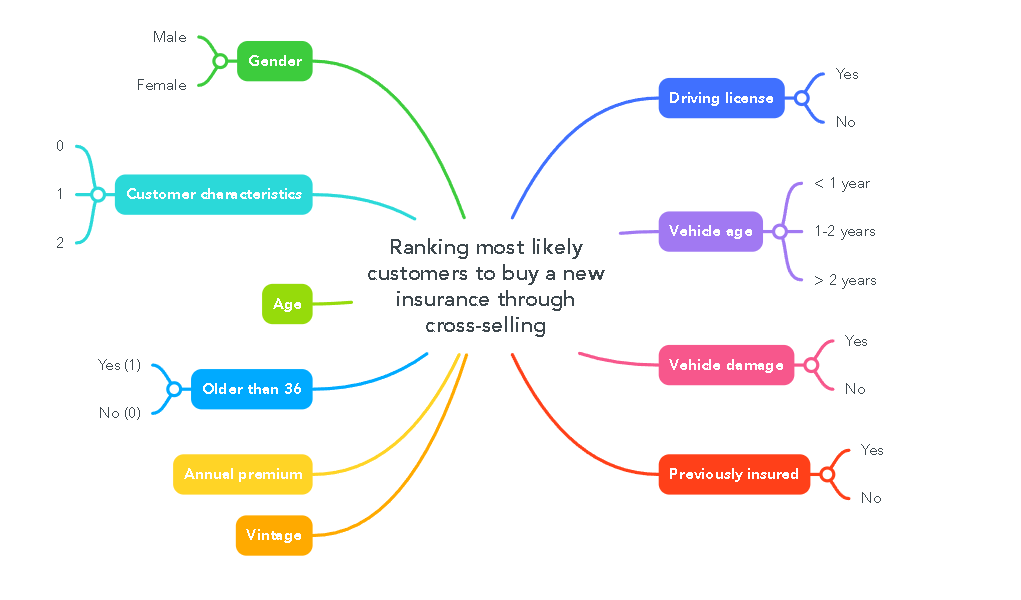

In [24]:
Image('../imgs/mind-map.png')

## Hypotheses list

ID     | Hypothesis | Relevance | Conclusions
-------|------------|-----------|-------------
H01.   |Customers without driving licenses tend to want less vehicle insurance|<font color='blue'>Low</font>|<font color='green'>True</font>
H02.   |Women tend to want more vehicle insurance| <font color='yellow'>Medium</font>| <font color='red'>False</font>
H03.   |Customers aged between 36-45 tend to want more vehicle insurance|<font color='yellow'>Medium</font>|<font color='red'>False</font>
H04.   |Customers with a history of damage to their vehicle tend to want more vehicle insurance|<font color='red'>High</font>|<font color='green'>True</font>
H05.   |Customers with new vehicles (< 1 year) tend to want more vehicle insurance|<font color='red'>High</font> |<font color='red'>False</font>

### 3.2.1. Hypothesis 01 - Customers without driving licenses tend to want less vehicle insurance
<font color='green'>True</font>

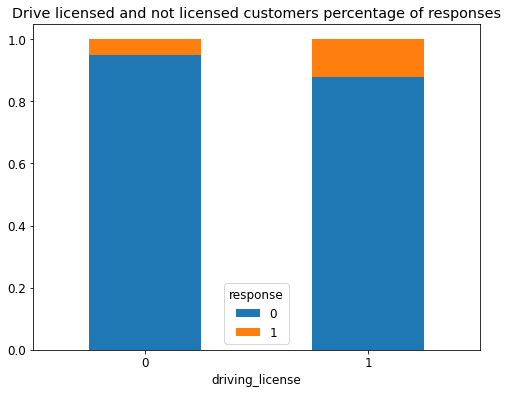

In [25]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['driving_license'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Drive licensed and not licensed customers percentage of responses');
plt.xticks(rotation=0);

### 3.2.2. Hypothesis 02 - Women tend to want more vehicle insurance
<font color='red'>False</font>

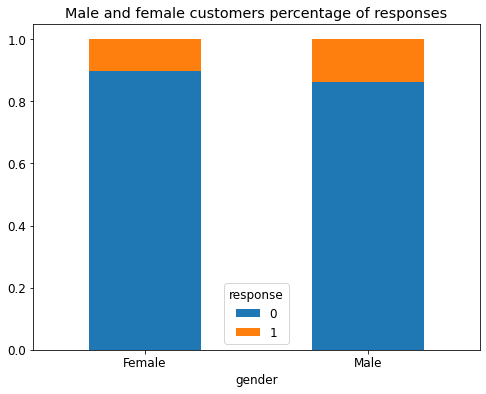

In [26]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['gender'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Male and female customers percentage of responses');
plt.xticks(rotation=0);

### 3.2.3. Hypothesis 03 - Customers aged between 36-45 tend to want more vehicle insurance
<font color='red'>False</font>

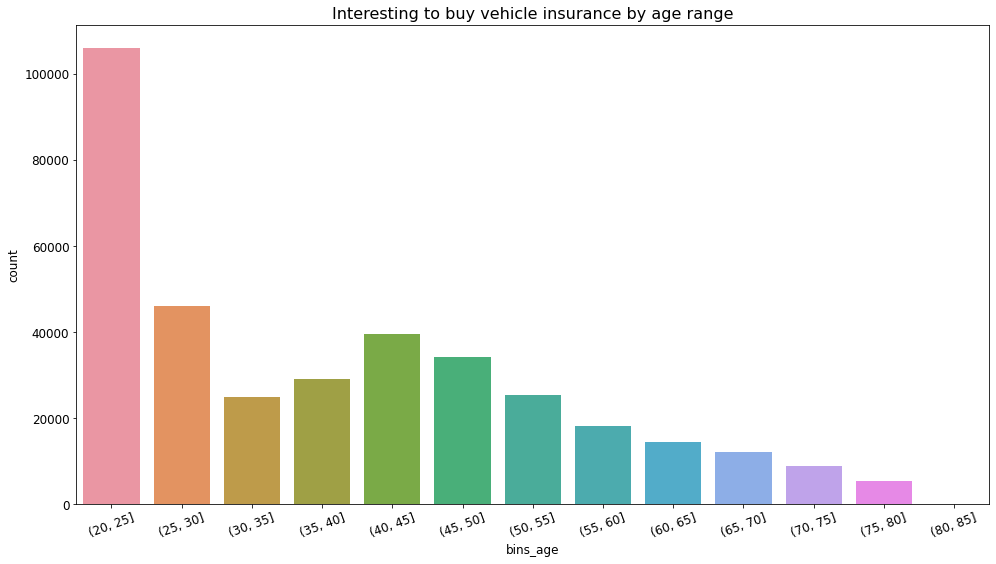

In [27]:
# define data
aux = df.copy()

# bins
n_bins = list(np.arange(df['age'].min(), df['age'].max()+1, 5))
aux['bins_age'] = pd.cut(aux['age'], bins=n_bins)

# plot
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))
sns.countplot(aux['bins_age'], ax=ax);
plt.title('Interesting to buy vehicle insurance by age range', fontsize=16);
plt.xticks(rotation=20);
plt.tight_layout()

### 3.2.4. Hypothesis 04 - Customers with a history of damage to their vehicle tend to want more vehicle insurance
<font color='green'>True</font>

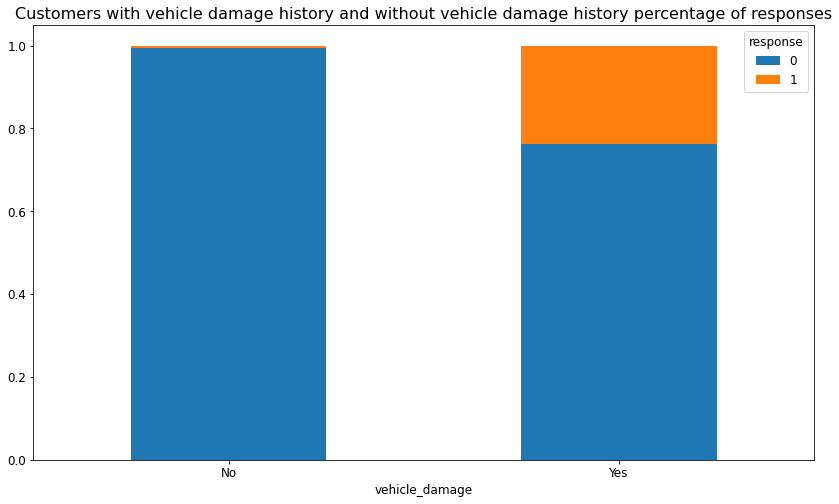

In [28]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))
pd.crosstab(df['vehicle_damage'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Customers with vehicle damage history and without vehicle damage history percentage of responses', fontsize=16);
plt.xticks(rotation=0);

### 3.2.5. Hypothesis 05 - Customers with new vehicles (< 1 year) tend to want more vehicle insurance
<font color='red'>False</font>

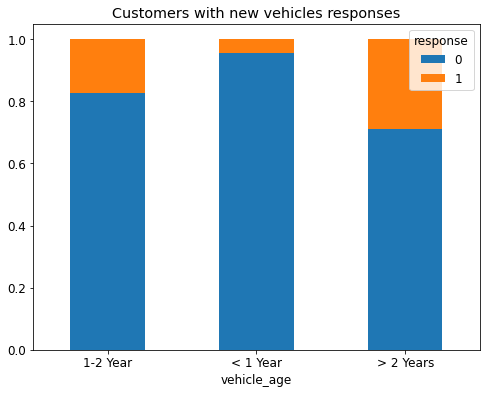

In [29]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['vehicle_age'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Customers with new vehicles responses');
plt.xticks(rotation=0);

## 3.3. Multivariate analysis

### 3.3.1. Numerical variables

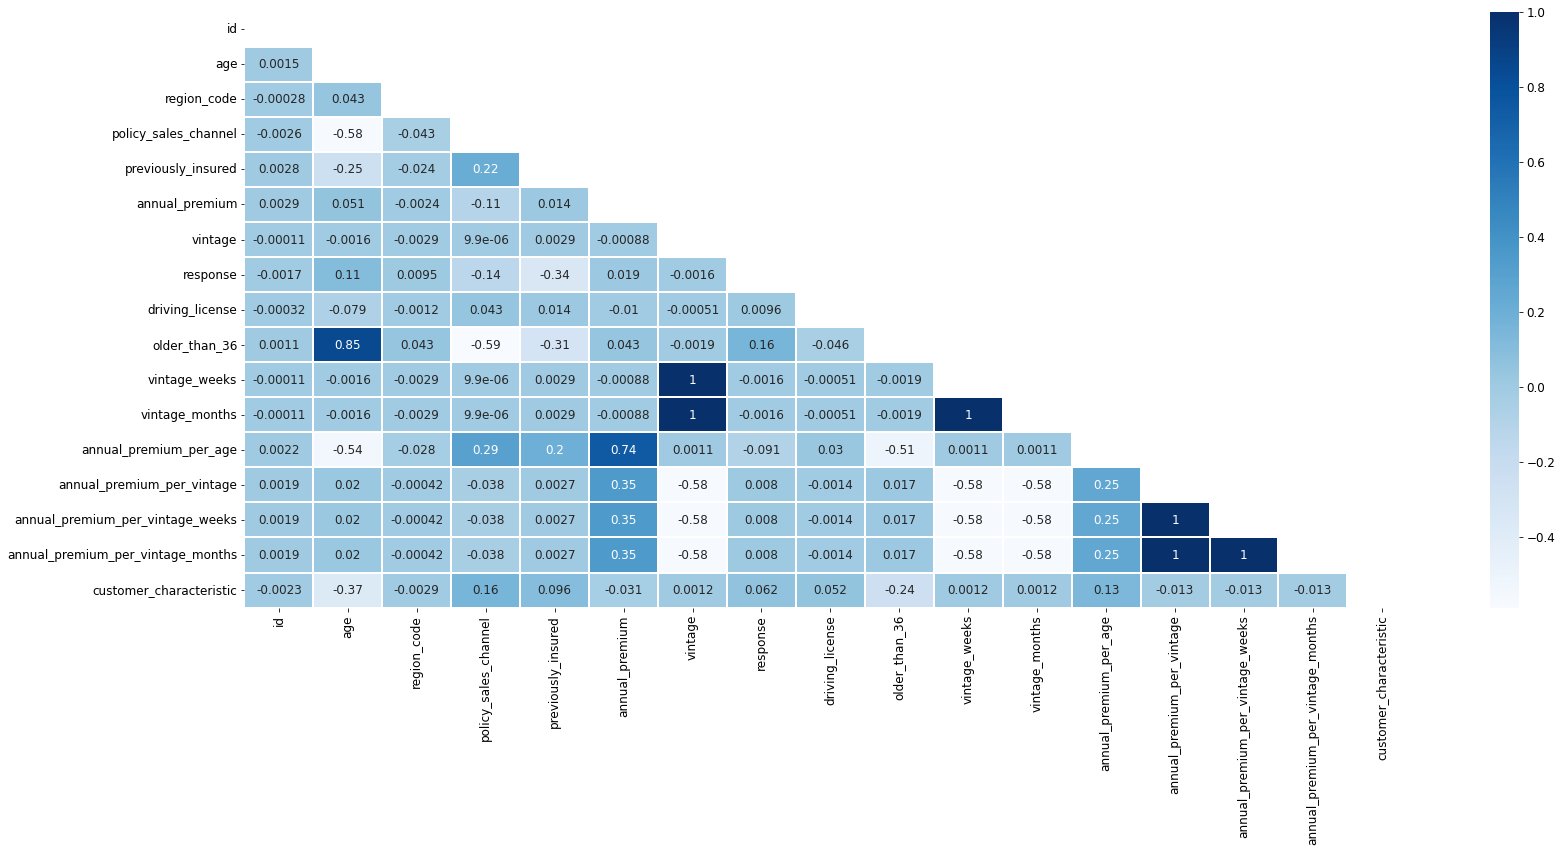

In [30]:
# compute the correlation matrix
num_corr = df.select_dtypes(include=['int64', 'float64']).corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(num_corr, dtype=bool))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(num_corr, mask=mask, cmap='Blues', annot=True, linewidths=2);
plt.tight_layout()

### 3.3.2. Categorical variables

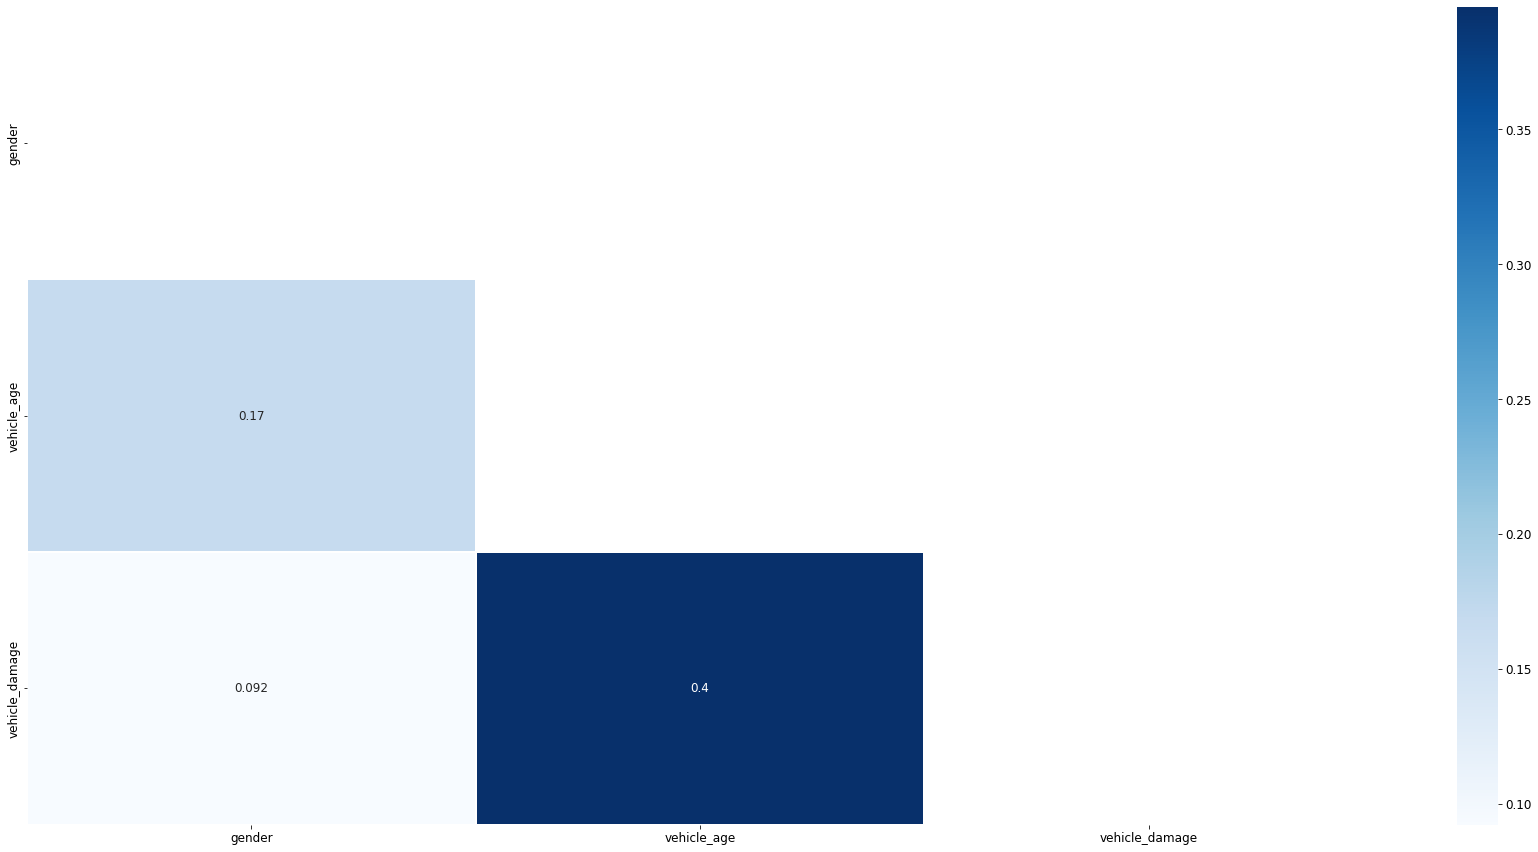

In [31]:
df_cat_var = df.select_dtypes(include='object').astype('category')

dict_cat_var_corr = dict()
for x in df_cat_var.columns:

    dict_cat_var_corr[x] = list()
    for y in df_cat_var.columns:
        # calculate cramer's v
        dict_cat_var_corr[x].append(mtb.cramers_v(df_cat_var[x], df_cat_var[y]))
    
    # store results
    df_cat_corr = pd.DataFrame(dict_cat_var_corr).set_index(df_cat_var.columns)

# plot settings
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))

# plot
sns.heatmap(df_cat_corr, mask=mask, cmap='Blues', annot=True, linewidths=2);
plt.tight_layout()

# 4. Data preprocessing

## 4.1. Data split

In [153]:
# split data into features and target variable
x = df.drop('response', axis=1)
y = df['response']

In [154]:
# create test data set
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.1)

# create train and validation data sets
x_train, x_val, y_train, y_val = ms.train_test_split(x_train, y_train, test_size=0.2)

In [155]:
# check them out
print(f'Train X: {x_train.shape} | Train Y: {y_train.shape}')
print(f'Val X: {x_val.shape} | Val Y: {y_val.shape}')
print(f'Test X: {x_test.shape} | Test Y: {y_test.shape}')

Train X: (266968, 19) | Train Y: (266968,)
Val X: (66742, 19) | Val Y: (66742,)
Test X: (37079, 19) | Test Y: (37079,)


## 4.2. Standardization

In [156]:
# instantiate the scaler
ss = pp.StandardScaler()

# define columns to be rescaled
cols_to_standardize = ['annual_premium', 'annual_premium_per_age']

# rescale
for col in cols_to_standardize:
    x_train.loc[:, cols_to_standardize] = ss.fit_transform(x_train.loc[:, cols_to_standardize])
    joblib.dump(ss, f'../parameters/ss_{col}.pkl')
    x_val.loc[:, cols_to_standardize] = ss.transform(x_val.loc[:, cols_to_standardize])
    x_test.loc[:, cols_to_standardize] = ss.transform(x_test.loc[:, cols_to_standardize])

## 4.3. Rescale

### 4.3.1 MinMax scaler

In [157]:
# instantiate the scaler
mm = pp.MinMaxScaler()

# define columns to be rescaled
cols_to_mm_rescale = ['age', 'vintage', 'vintage_weeks', 'vintage_months', 'customer_characteristic',
                      'annual_premium', 'annual_premium_per_age']

# rescale
for col in cols_to_mm_rescale:
    x_train.loc[:, cols_to_mm_rescale] = mm.fit_transform(x_train.loc[:, cols_to_mm_rescale])
    joblib.dump(mm, f'../parameters/mm_{col}.pkl')
    x_val.loc[:, cols_to_mm_rescale] = mm.transform(x_val.loc[:, cols_to_mm_rescale])
    x_test.loc[:, cols_to_mm_rescale] = mm.transform(x_test.loc[:, cols_to_mm_rescale])

### 4.3.2. Robust scaler

In [158]:
# instantiate the scaler
rs = pp.RobustScaler()

# define columns to be rescaled
cols_to_rs_rescale = ['annual_premium_per_vintage', 'annual_premium_per_vintage_weeks', 'annual_premium_per_vintage_months']

# rescale
for col in cols_to_rs_rescale:
    x_train.loc[:, cols_to_rs_rescale] = rs.fit_transform(x_train.loc[:, cols_to_rs_rescale])
    joblib.dump(rs, f'../parameters/rs_{col}.pkl')
    x_val.loc[:, cols_to_rs_rescale] = rs.transform(x_val.loc[:, cols_to_rs_rescale])
    x_test.loc[:, cols_to_rs_rescale] = rs.transform(x_test.loc[:, cols_to_rs_rescale])

## 4.4. Encoding

### 4.4.1. One-hot encoding

In [159]:
# define columns to encode
cols_to_ohe_encode = ['gender', 'vehicle_age', 'vehicle_damage']

# encode
x_train = pd.get_dummies(x_train, columns=cols_to_ohe_encode, drop_first=True)
x_val = pd.get_dummies(x_val, columns=cols_to_ohe_encode, drop_first=True)
x_test = pd.get_dummies(x_test, columns=cols_to_ohe_encode, drop_first=True)

### 4.4.2. Frequency encoding

In [160]:
# encode
## x_train
col_frequency = x_train.groupby('policy_sales_channel').size() / len(x_train)
x_train.loc[:, 'policy_sales_channel'] = x_train.loc[:, 'policy_sales_channel'].map(col_frequency)

col_frequency = x_train.groupby('region_code').size() / len(x_train)
x_train.loc[:, 'region_code'] = x_train.loc[:, 'region_code'].map(col_frequency)

## x_val
col_frequency = x_val.groupby('policy_sales_channel').size() / len(x_val)
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:, 'policy_sales_channel'].map(col_frequency)

col_frequency = x_val.groupby('region_code').size() / len(x_val)
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map(col_frequency)

## x_test
col_frequency = x_test.groupby('policy_sales_channel').size() / len(x_test)
x_test.loc[:, 'policy_sales_channel'] = x_test.loc[:, 'policy_sales_channel'].map(col_frequency)

col_frequency = x_test.groupby('region_code').size() / len(x_test)
x_test.loc[:, 'region_code'] = x_test.loc[:, 'region_code'].map(col_frequency)

# 5. Feature selection

In [161]:
x_train.drop('id', axis=1, inplace=True)
x_val.drop('id', axis=1, inplace=True)

## 5.1. Boruta as selector

In [92]:
# instantiate the classifier
boruta_xtree = ExtraTreesClassifier()

# instantiate the selector
boruta_selector = BorutaPy(estimator=boruta_xtree, n_estimators=100, verbose=1).fit(x_train.values, y_train.values)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100


BorutaPy finished running.

Iteration: 	30 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	16


In [94]:
# selected columns by boruta
selected_features_boruta = [col for col, sbcol in zip(x_train.columns, boruta_selector.support_.tolist()) if sbcol]
selected_features_boruta

['age', 'previously_insured', 'vehicle_damage_Yes']

## 5.2. Extra trees as selector

In [122]:
# instantiate and fit the classifier
xtrees_selector = ExtraTreesClassifier(n_estimators=200).fit(x_train, y_train)

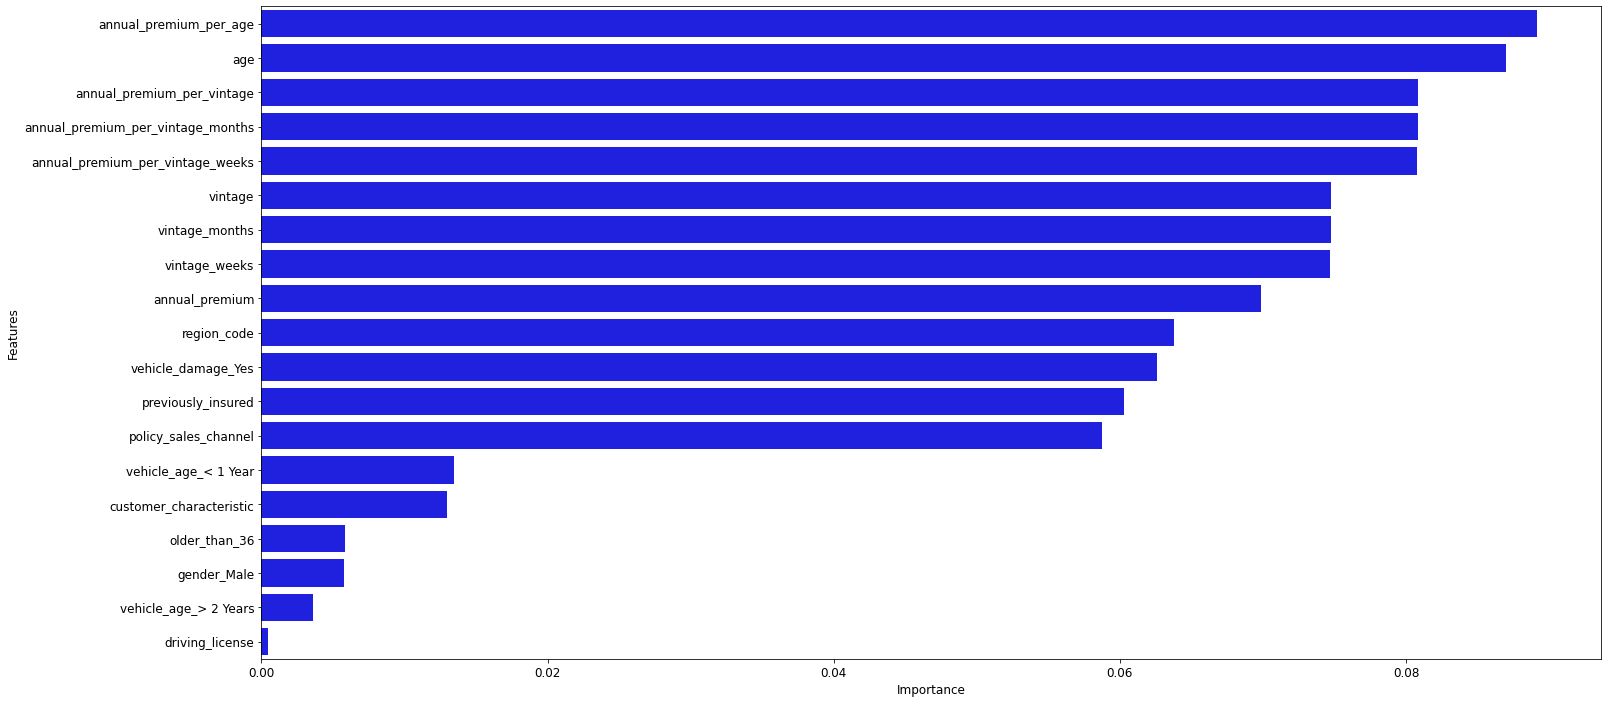

In [123]:
# store features importance
df_xtrees_selector = pd.DataFrame({'Features': x_train.columns,
                               'Importance': xtrees_selector.feature_importances_})\
                               .sort_values(by='Importance', ascending=False)\
                               .reset_index(drop=True)

# plot
sns.barplot(x='Importance', y='Features', data=df_xtrees_selector, orient='h', color='blue');

## 5.3. Columns selection

In [162]:
selected_columns = ['id', 'vehicle_damage_Yes', 'annual_premium_per_age', 'annual_premium_per_vintage']

# select columns
x_train = x_train.loc[:, selected_columns[1::]]
x_val = x_val.loc[:, selected_columns[1::]]
x_test = x_test.loc[:, selected_columns]

# check it out
x_test.sample(3)

,id,vehicle_damage_Yes,annual_premium_per_age,annual_premium_per_vintage
124201,229458,1,0.247,0.697
254401,127436,1,0.161,-0.200
225935,280297,0,0.010,-0.721


# 6. Machine learning modeling

In [165]:
# define K
K = np.floor((1/2) * (y_val.shape[0]))

## 6.1. KNN

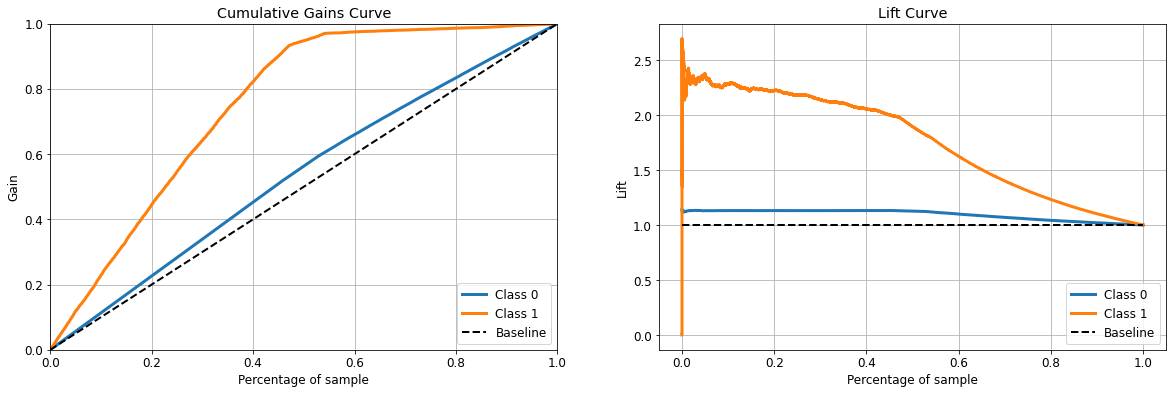

In [166]:
# instantiate and fit the model
clf_knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)

# predict
p_hat_knn = clf_knn.predict_proba(x_val)

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# plot cumulative gain
plot_cumulative_gain(y_val, p_hat_knn, ax=ax1);

# plot lift curve
plot_lift_curve(y_val, p_hat_knn, ax=ax2);

In [167]:
# prepare data set
aux = x_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_knn, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_knn, K)}')

Precision@K: 0.2347
Recall@K: 0.9493


### 6.1.1. KNN cross-validation

In [168]:
cross_validation(estimator=KNeighborsClassifier(n_neighbors=20), x=x_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.2311 +/- 0.0011
Recall@K: 0.9518 +/- 0.0043


## 6.2. Logistic regression

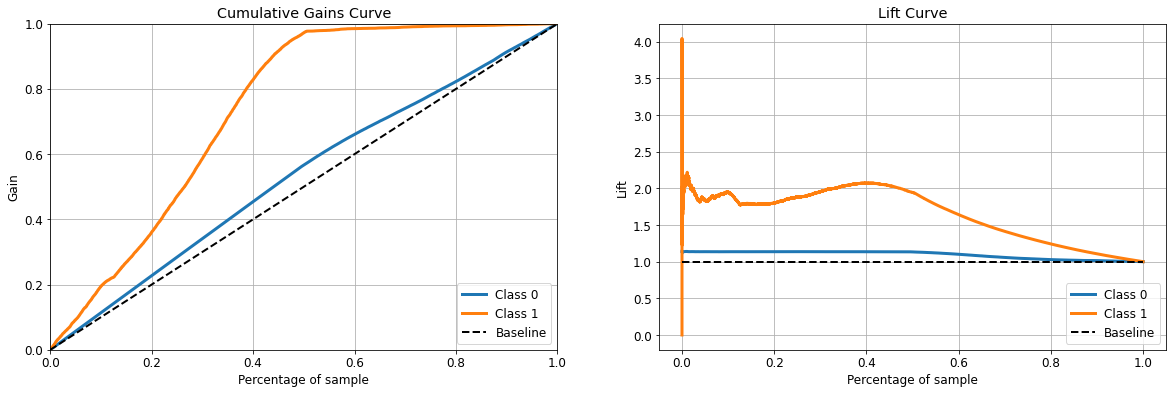

In [169]:
# instantiate and fit the model
clf_lr = LogisticRegression().fit(x_train, y_train)

# predict
p_hat_lr = clf_lr.predict_proba(x_val)

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# plot cumulative gain
plot_cumulative_gain(y_val, p_hat_lr, ax=ax1);

# plot lift curve
plot_lift_curve(y_val, p_hat_lr, ax=ax2);

In [170]:
# prepare data set
aux = x_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_lr, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_lr, K)}')

Precision@K: 0.2403
Recall@K: 0.9719


### 6.2.1. Logistic regression cross-validation

In [171]:
cross_validation(estimator=LogisticRegression(), x=x_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.2373 +/- 0.0008
Recall@K: 0.9774 +/- 0.0033


## 6.3. Random forest

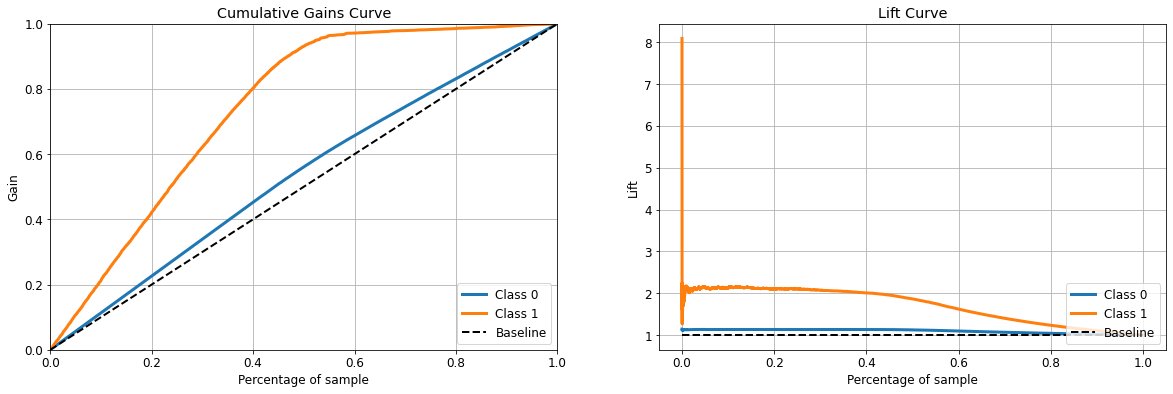

In [172]:
# instantiate and fit the model
clf_rf = RandomForestClassifier(n_estimators=500).fit(x_train, y_train)

# predict
p_hat_rf = clf_rf.predict_proba(x_val)

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# plot cumulative gain
plot_cumulative_gain(y_val, p_hat_rf, ax=ax1);

# plot lift curve
plot_lift_curve(y_val, p_hat_rf, ax=ax2);

In [173]:
# prepare data set
aux = x_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_rf, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_rf, K)}')

Precision@K: 0.23
Recall@K: 0.9303


### 6.3.1. Random forest cross-validation

In [174]:
cross_validation(estimator=RandomForestClassifier(), x=x_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.2264 +/- 0.0011
Recall@K: 0.9325 +/- 0.0044


## 6.4. LightGBM

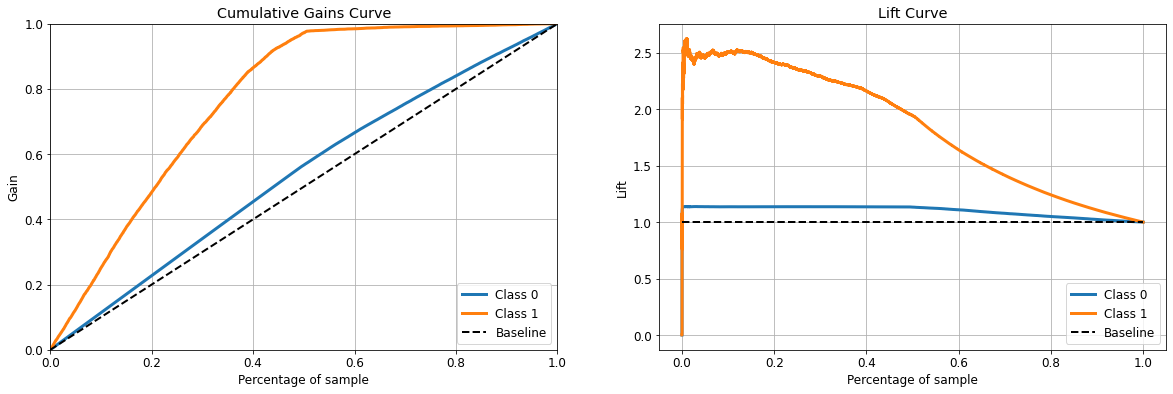

In [175]:
# instantiate and fit the model
clf_lgbm = LGBMClassifier().fit(x_train, y_train)

# predict
p_hat_lgbm = clf_lgbm.predict_proba(x_val)

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# plot cumulative gain
plot_cumulative_gain(y_val, p_hat_lgbm, ax=ax1);

# plot lift curve
plot_lift_curve(y_val, p_hat_lgbm, ax=ax2);

In [176]:
# prepare data set
aux = x_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_lgbm, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_lgbm, K)}')

Precision@K: 0.2403
Recall@K: 0.972


### 6.4.1. LightGBM cross-validation

In [177]:
cross_validation(estimator=LGBMClassifier(), x=x_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.2373 +/- 0.0007
Recall@K: 0.9771 +/- 0.0029


## 6.5. Catboost

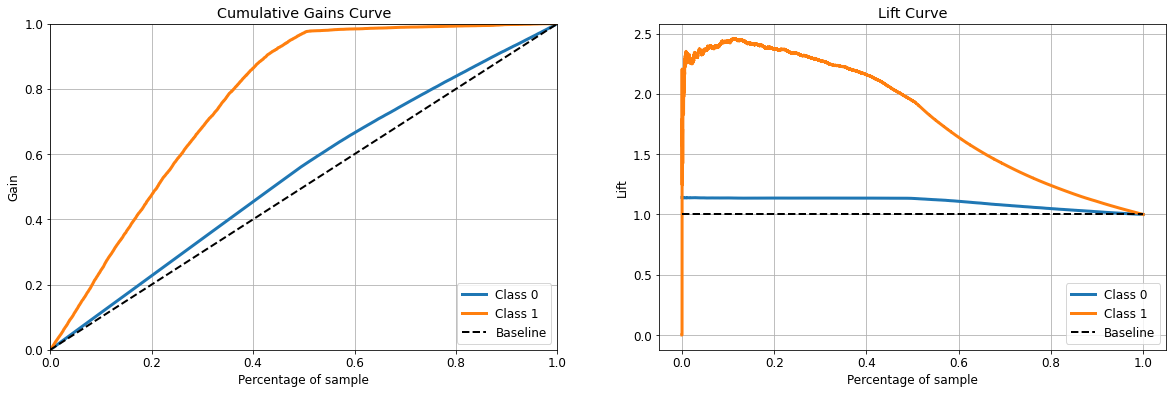

In [178]:
# instantiate and fit the model
clf_cb = CatBoostClassifier(verbose=False).fit(x_train, y_train, verbose=False)

# predict
p_hat_cb = clf_cb.predict_proba(x_val)

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# plot cumulative gain
plot_cumulative_gain(y_val, p_hat_cb, ax=ax1);

# plot lift curve
plot_lift_curve(y_val, p_hat_cb, ax=ax2);

In [179]:
# prepare data set
aux = x_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_cb, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_cb, K)}')

Precision@K: 0.2402
Recall@K: 0.9715


### 6.5.1. Catboost cross-validation

In [180]:
cross_validation(estimator=CatBoostClassifier(verbose=False), x=x_train, y=y_train,
                 n_splits=10, shuffle=True, verbose=False)

Precision@K: 0.2374 +/- 0.0006
Recall@K: 0.9775 +/- 0.0023


# 7. Hyperparameters fine tuning

## 7.1. Bayesian optimization

In [181]:
# set of parameters to try
params = {
    'max_depth': [-1, 5, 10, 15],
    'num_leaves': [80, 120, 160, 200, 300, 500],
    'learning_rate': [0.1, 1]
}

# instantiate and fit the optimzier
opt = BayesSearchCV(LGBMClassifier(), params, n_iter=10, cv=5).fit(x_train, y_train)

In [182]:
opt.best_estimator_

LGBMClassifier(learning_rate=0.34185702278663666, max_depth=5, num_leaves=160)

## 7.2. Evaluate tuned model

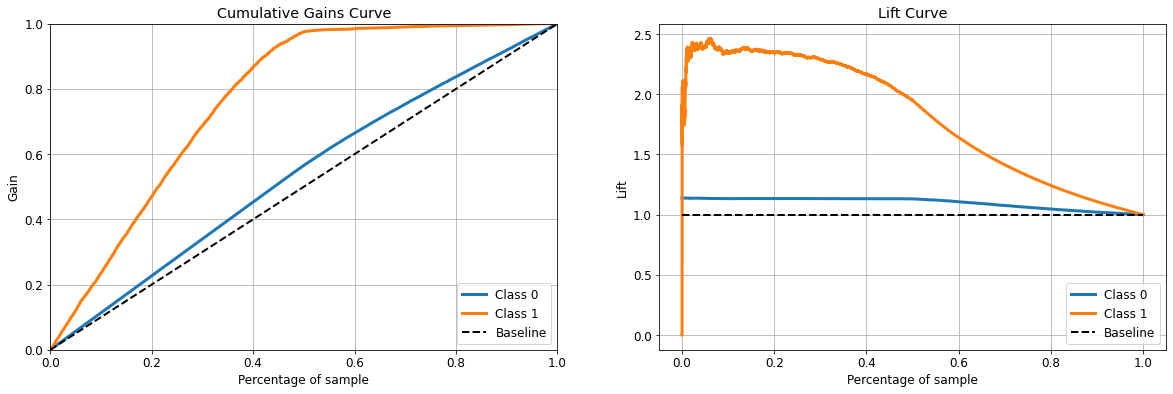

In [183]:
# instantiate and fit the model
model = LGBMClassifier(learning_rate=0.3, max_depth=5, num_leaves=160).fit(x_train, y_train)

# predict
p_hat = model.predict_proba(x_test.drop('id', axis=1))

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# cumulative gain
plot_cumulative_gain(y_test, p_hat, ax=ax1);

# lift curve
plot_lift_curve(y_test, p_hat, ax=ax2);

In [184]:
# prepare data set
aux = x_test.drop('id', axis=1).copy()
aux['response'] = y_test.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat, K)}')

Precision@K: 0.1341
Recall@K: 0.9964


# 8. Calibration

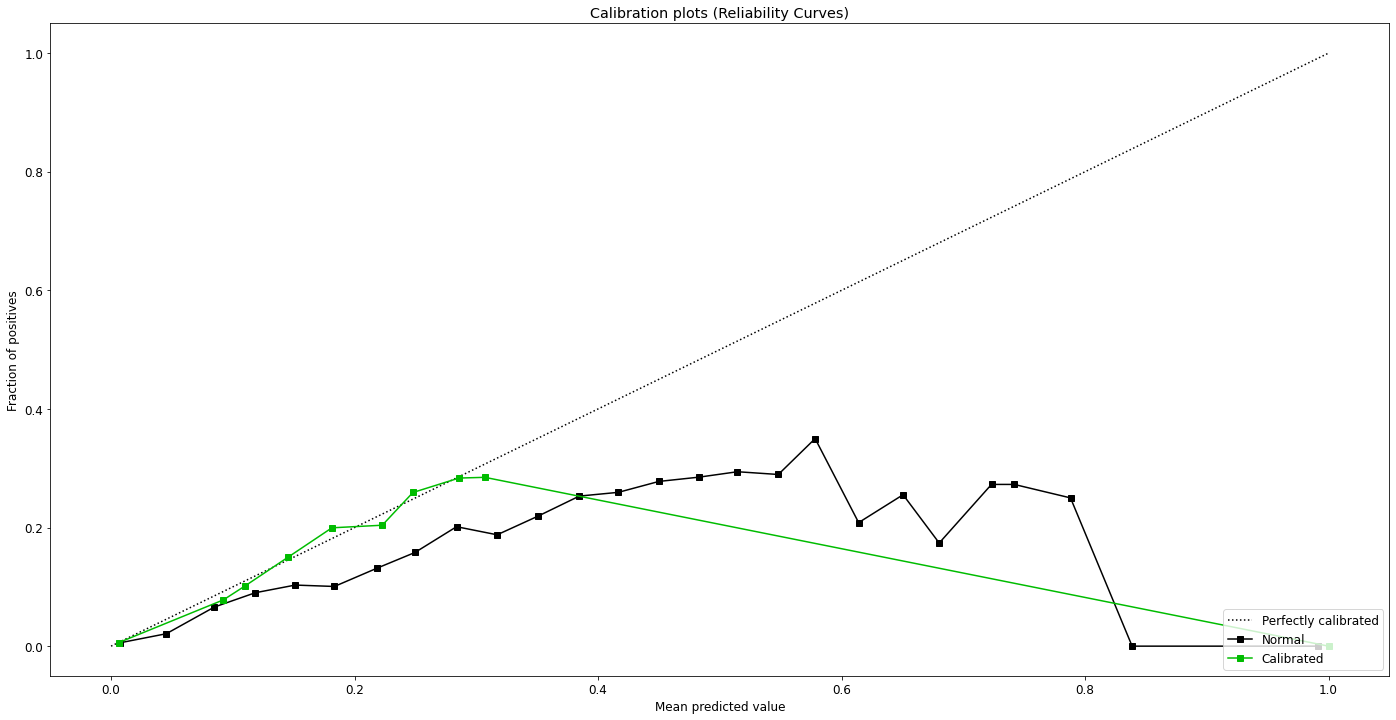

In [188]:
# calibrate the model
model_calibrated = CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit').fit(x_val, y_val)
joblib.dump(model_calibrated, '../models/model.pkl')

# predict
p_hat_calibrated = model_calibrated.predict_proba(x_test.drop('id', axis=1))

# plot calibration curve
plot_calibration_curve(y_true=y_test,
                       clf_names=['Normal', 'Calibrated'],
                       probas_list=[p_hat, p_hat_calibrated],
                       n_bins=30);

## 8.1. Evaluate calibrated model

In [189]:
# calculate brier score loss for each model
bsl_model = brier_score_loss(y_test, p_hat[:, 1])
bsl_model_calibrated = brier_score_loss(y_test, p_hat_calibrated[:, 1])

# compare them
print(f'Brier score loss before the calibration: {bsl_model}')
print(f'Brier score loss after the calibration: {bsl_model_calibrated}\n')

# check it out
if bsl_model_calibrated > bsl_model:
    print('Calibrated model is NOT better.')
else:
    print('Calibrated model is better.')

Brier score loss before the calibration: 0.09160960043140634
Brier score loss after the calibration: 0.09150856327361925

Calibrated model is better.


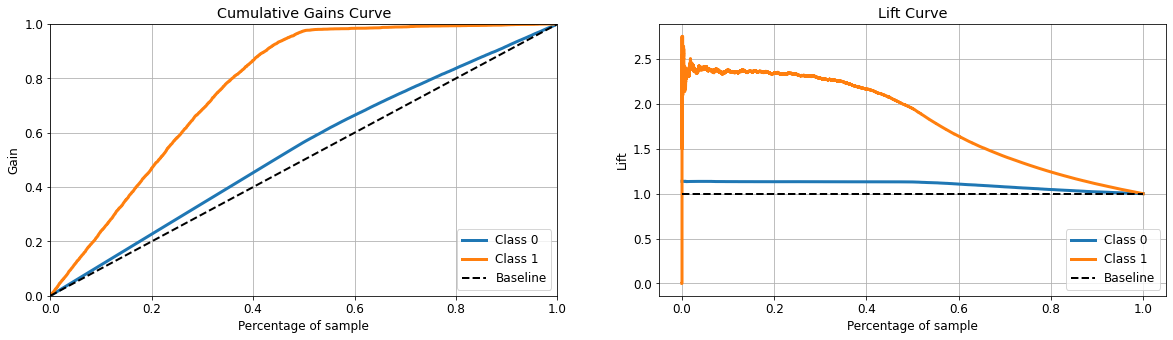

In [190]:
# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
(ax1, ax2) = ax

# plot cumulative gain
plot_cumulative_gain(y_test, p_hat_calibrated, ax=ax1);

# plot lift curve
plot_lift_curve(y_test, p_hat_calibrated, ax=ax2);

In [191]:
# prepare data set
aux = x_test.drop('id', axis=1).copy()
aux['response'] = y_test.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_calibrated, K)}')

# calculate recall at k
print(f'Recal@K: {recall_at_k(aux, p_hat_calibrated, K)}')

Precision@K: 0.1342
Recal@K: 0.9978


# 9. Deploy

## 9.1. Pipeline class